# 1. Environment Setup

## 1.1 Libarary Imports

In [1]:
%pip install urllib3 xarray numpy pandas tqdm pillow matplotlib plotly seaborn scikit-learn tensorflow keras-tuner netCDF4 h5netcdf


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
# Data Formatting
import urllib.request
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4
import h5netcdf
from tqdm import tqdm
import os
from PIL import Image

# Data Viz
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Data Processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

# CNN + LSTM
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, Reshape, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D, Input, Reshape
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

## 1.2 Download Data

In [3]:
# NOAA Data API call
for yr in range(2010, 2023):
    url = f'https://downloads.psl.noaa.gov/Datasets/cpc_us_precip/RT/precip.V1.0.{yr}.nc'
    savename = url.split('/')[-1]
    urllib.request.urlretrieve(url, savename)
    print(f"Downloaded {savename}")

Downloaded precip.V1.0.2010.nc
Downloaded precip.V1.0.2011.nc
Downloaded precip.V1.0.2012.nc
Downloaded precip.V1.0.2013.nc
Downloaded precip.V1.0.2014.nc
Downloaded precip.V1.0.2015.nc
Downloaded precip.V1.0.2016.nc
Downloaded precip.V1.0.2017.nc
Downloaded precip.V1.0.2018.nc
Downloaded precip.V1.0.2019.nc
Downloaded precip.V1.0.2020.nc
Downloaded precip.V1.0.2021.nc
Downloaded precip.V1.0.2022.nc


## 1.3 Format code with Pandas
- **Data Loading:**  
   - The `load_data` function reads NetCDF files, extracting:
     - *Precipitation Data:* 3D array `(time, latitude, longitude)`.
     - *Metadata:* Full dataset object for additional attributes.
     - *Time:* Array of time points.  
   - Outputs a list of tuples `(data, ds, time)`.

- **Input Data:**  
   - Generates filenames for precipitation data (2010 to 2015).

In [ ]:
# Load the data
def load_data(filenames):
    datasets = []
    for filename in filenames:
        ds = xr.open_dataset(filename)
        data = ds['precip'].values  # Shape: (time, lat, lon)
        time = ds['time'].values
        datasets.append((data, ds, time))
    return datasets

# List of downloaded files
filenames = [f'precip.V1.0.{yr}.nc' for yr in range(2010, 2016)]
datasets = load_data(filenames)

# Output directory for saved plots
output_dir = "monthly_precipitation_maps"
os.makedirs(output_dir, exist_ok=True)

# 2. Data Visualization
**Why Visualize Data?**  
- Visualizing data helps identify trends, patterns, and anomalies that may not be obvious from raw numbers. Furthermore, it allows us to verify the accuracy of our data processing.

**How the Code Works:**  
  - Summing precipitation values over time for each year.
  - Mapping these totals spatially using latitude and longitude coordinates.
  - Adding a unified colorbar for interpretation.  

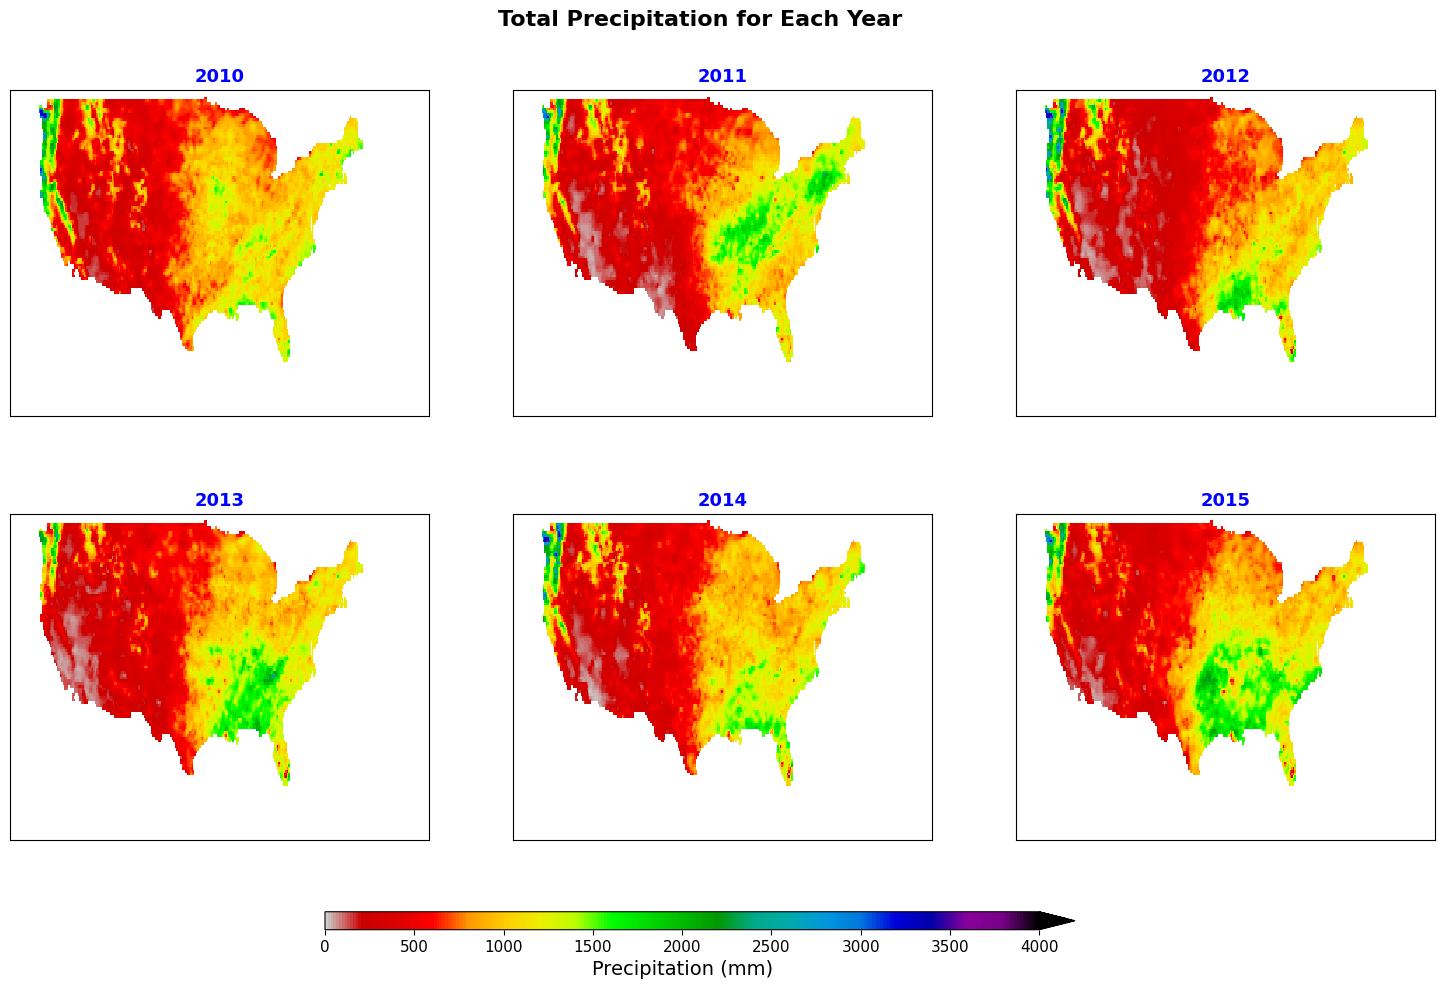

In [17]:
# Plot average yearly data
fig = plt.figure(figsize=[15, 10], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.90, left=0.04, right=0.99,
                    wspace=0.2, hspace=0.3)

plt.suptitle('Total Precipitation for Each Year', fontsize=16, fontweight='bold')

nrows = 2
ncols = 3
years = range(2010, 2016)
# Adjust the loop to unpack three values: data, ds, and time
for i, (data, ds, time) in enumerate(datasets, start=1):
    # Calculate the sum over time for each lat/lon
    total_precip = np.sum(data, axis=0)

    # Extract latitude and longitude
    lat = ds['lat'].values
    lon = ds['lon'].values

    # Create a subplot for each year
    plt.subplot(nrows, ncols, i)
    p = plt.pcolormesh(lon, lat, total_precip,
                       vmax=4000, vmin=0, cmap='nipy_spectral_r')
    plt.xlim([lon.min(), lon.max()])
    plt.ylim([lat.min(), lat.max()])

    # Remove tick marks
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{years[i-1]}', fontsize=13,
              fontweight='bold', color='b')

# Add a colorbar at the bottom
cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
cb = plt.colorbar(p, cax=cax, orientation='horizontal', extend='max')
cb.ax.tick_params(labelsize=11)
cb.set_label(label='Precipitation (mm)', color='k', size=14)

plt.show()

# 3. Preprocess Data
Preprocessing and formatting ensure that raw data is structured for meaningful analysis and visualization. Aggregating data by time periods (e.g., months) enables focused insights into temporal trends, critical for applications like climate monitoring.

This script processes precipitation data by months, creating visual summaries for each period:
  1. *Temporal Formatting:* Converts time data to pandas datetime format for efficient manipulation and filtering by month.
  2. *Aggregation:* Calculates average monthly precipitation for each grid cell across latitude and longitude.
  3. *Visualization:* Generates heatmaps of spatial precipitation patterns for each month.
  4. *Output:* Saves the heatmaps as individual image files, organized by date, for further analysis or presentation.

In [18]:
# Plot monthly data and save the figures
for i, (data, ds, time) in enumerate(datasets):
    # Extract latitude and longitude
    lat = ds['lat'].values
    lon = ds['lon'].values

    # Convert time to pandas datetime for easier manipulation
    time_pd = pd.to_datetime(time)

    # Get the unique years and months in the dataset
    unique_months = time_pd.to_period('M').unique()

    # Loop through each month
    for month in tqdm(unique_months, desc=f"Processing {2010 + i}"):
        # Find indices corresponding to the current month
        month_indices = (time_pd.to_period('M') == month)

        # Aggregate data for the current month
        monthly_precip = np.nanmean(data[month_indices, :, :], axis=0)

        # Get the start and end dates of the month
        month_start_date = time_pd[month_indices].min().strftime('%Y-%m-%d')
        month_end_date = time_pd[month_indices].max().strftime('%Y-%m-%d')

        # Create a figure for each month
        fig, ax = plt.subplots(figsize=[10, 7], facecolor='w')
        plt.title(f"Precipitation from {month_start_date} to {month_end_date}")

        # Create the heatmap
        plt.axis('off')
        p = ax.pcolormesh(lon, lat, monthly_precip, vmax=150, vmin=0, cmap='nipy_spectral_r')
        plt.xlim([lon.min(), lon.max()])
        plt.ylim([lat.min(), lat.max()])

        # Save the figure
        filename = os.path.join(output_dir, f'precipitation_{month_start_date}_to_{month_end_date}.png')
        plt.savefig(filename)
        plt.close(fig)

Processing 2010:   0%|          | 0/12 [00:00<?, ?it/s]/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_34002/4061049619.py:19: RuntimeWarning: Mean of empty slice
  monthly_precip = np.nanmean(data[month_indices, :, :], axis=0)
Processing 2011:   0%|          | 0/12 [00:00<?, ?it/s]/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_34002/4061049619.py:19: RuntimeWarning: Mean of empty slice
  monthly_precip = np.nanmean(data[month_indices, :, :], axis=0)
Processing 2012:   0%|          | 0/12 [00:00<?, ?it/s]/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_34002/4061049619.py:19: RuntimeWarning: Mean of empty slice
  monthly_precip = np.nanmean(data[month_indices, :, :], axis=0)
Processing 2013:   0%|          | 0/12 [00:00<?, ?it/s]/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_34002/4061049619.py:19: RuntimeWarning: Mean of empty slice
  monthly_precip = np.nanmean(data[month_indices, :, :], axis=0)
Processing 2014:   0%|          | 0/12 [00:0

In [19]:
# Directory containing the images
image_dir = 'monthly_precipitation_maps'

# Load image file names and extract dates
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
dates = [f.split('_')[1].split('.')[0] for f in image_files]

# Load images and convert to numpy arrays
def load_images(image_dir, image_files):
    images = []
    for file in tqdm(image_files):
        img_path = os.path.join(image_dir, file)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((500, 350))  # Resize images to match input size of CNN
        img_array = np.array(img) / 255.0
        images.append(img_array)
    return np.array(images)

# Load images
X = load_images(image_dir, image_files)

100%|██████████| 72/72 [00:00<00:00, 74.57it/s]


In [20]:
# Create sequences of images and their corresponding targets
def create_sequences(X, seq_length):
    sequences = []
    targets = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i + seq_length])
        targets.append(X[i + seq_length])
    return np.array(sequences), np.array(targets)

# Create sequences
seq_length = 4  # Number of months to look back
X_seq, y_seq = create_sequences(X, seq_length)

In [21]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# 4. CNN + LSTM Model

## Model Performance Functions
Evaluating model performance helps ensure that it generalizes well to unseen data, preventing overfitting or underfitting. Metrics like loss and R² provide insights into how effectively the model learns and predicts.

This function combines visualization and metrics to assess model training and testing:
  1. *Loss Tracking:* Plots training and validation loss over epochs to reveal trends like convergence or overfitting.
  2. *Prediction and Evaluation:* Predicts test data outputs and calculates the R² score, a measure of how well predictions match true values.
  3. *Insightful Output:* The loss plot and R² score together provide a comprehensive view of model learning and generalization, aiding in fine-tuning and debugging.

In [26]:
def plot_loss_and_r2(model, history, X_test, y_test):
    """
    Plots the training and validation loss and computes R² for test data.

    Parameters:
    - model: Trained Keras model.
    - history: Training history object from model.fit().
    - X_test: Test data (features).
    - y_test: Test data (true labels/targets).

    Returns:
    - None
    """
    # Extract loss values from history
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    epochs = range(1, len(train_loss) + 1)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Predict on test data
    y_pred = model.predict(X_test)

    # Compute R² score
    r2 = r2_score(y_test.flatten(), y_pred.flatten())
    print(f"R² Score on Test Data: {r2:.4f}")

## 4.1 Base Model

Below is a simple deep learning model. This will give us a great place to start from and will serve as our baseline for future performances.

- **Input Layer:**  
   - Accepts a sequence of images, each with a shape of `(350, 500, 3)` (height, width, and channels). The sequence length is defined by `seq_length`.

- **TimeDistributed CNN Layers:**  
   - *Convolutional Layer:* Extracts spatial features from each image independently using 32 filters with a 3x3 kernel and ReLU activation.
   - *MaxPooling Layer:* Reduces spatial dimensions while retaining prominent features.
   - *Flatten Layer:* Converts the 2D feature maps into 1D vectors for sequential processing.

- **LSTM Layer:**  
   - Processes the sequence of feature vectors extracted by the CNN to learn temporal relationships.

- **Output Layer:**  
   - Fully connected dense layer predicts pixel-level values for the input sequence. The output is reshaped back to the original image shape.

- **Compilation:**  
   - The model uses the Adam optimizer and Mean Squared Error (MSE) loss, suitable for regression tasks.

In [24]:
def create_simple_cnn_lstm_model(seq_length, input_shape=(350, 500, 3)):
    # Input layer for a sequence of images
    inputs = tf.keras.Input(shape=(seq_length,) + input_shape)

    # Simple TimeDistributed CNN
    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
    )(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)

    # Simple LSTM layer
    x = tf.keras.layers.LSTM(64)(x)

    # Output layer (regression)
    outputs = tf.keras.layers.Dense(input_shape[0] * input_shape[1] * input_shape[2])(x)
    outputs = tf.keras.layers.Reshape(input_shape)(outputs)

    # Compile the model
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')

    return model

# Define sequence length and create the model
seq_length = 4  # Adjust based on your data
model = create_simple_cnn_lstm_model(seq_length)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4, 350, 500, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 4, 350, 500,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 4, 175, 250,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 4, 1400000)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │   358,416,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 525000)         │    34,125,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 350, 500, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,542,536 (1.46 GB)

 Trainable params: 392,542,536 (1.46 GB)

 Non-trainable params: 0 (0.00 B)

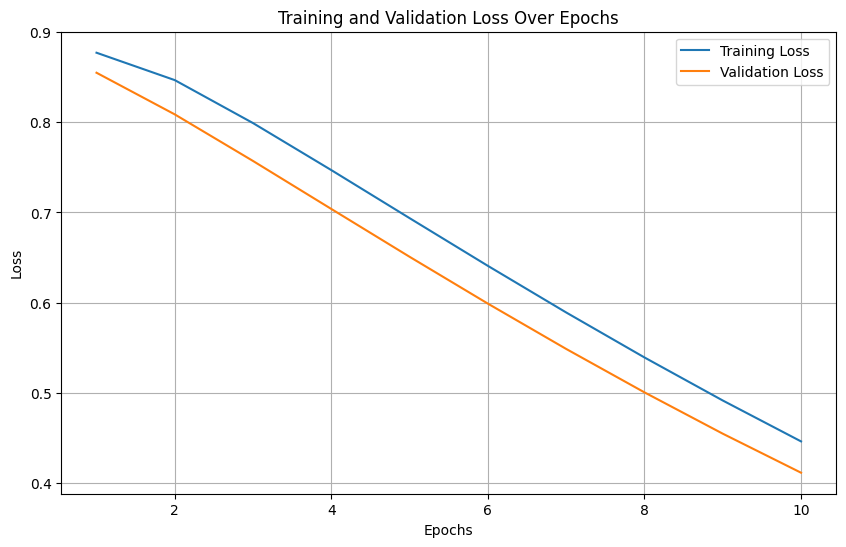

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
R² Score on Test Data: -14.0193


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
plot_loss_and_r2(model, history, X_test, y_test)

## 4.2 Increase Epochs

Seeing as the base model's performance was continuing to improve (negative slope), let's increase the number of epochs we train for. Let's also include early stopping for brevity's sake. 

In [39]:
def create_simple_cnn_lstm_model(seq_length, input_shape=(350, 500, 3)):
    # Input layer for a sequence of images
    inputs = tf.keras.Input(shape=(seq_length,) + input_shape)

    # Simple TimeDistributed CNN
    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
    )(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2)))(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)

    # Simple LSTM layer
    x = tf.keras.layers.LSTM(64)(x)

    # Output layer (regression)
    outputs = tf.keras.layers.Dense(input_shape[0] * input_shape[1] * input_shape[2])(x)
    outputs = tf.keras.layers.Reshape(input_shape)(outputs)

    # Compile the model
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')

    return model

# Define sequence length and create the model
seq_length = 4  # Adjust based on your data
model = create_simple_cnn_lstm_model(seq_length)
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 4, 350, 500, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 4, 350, 500,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 4, 175, 250,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 4, 1400000)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │   358,416,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 525000)         │    34,125,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 350, 500, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,542,536 (1.46 GB)

 Trainable params: 392,542,536 (1.46 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 18s/step - loss: 0.8784 - val_loss: 0.8534
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 18s/step - loss: 0.8475 - val_loss: 0.8020
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 14s/step - loss: 0.7953 - val_loss: 0.7441
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 15s/step - loss: 0.7370 - val_loss: 0.6847
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 13s/step - loss: 0.6772 - val_loss: 0.6258
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 15s/step - loss: 0.6186 - val_loss: 0.5684
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 15s/step - loss: 0.5615 - val_loss: 0.5134
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 17s/step - loss: 0.5068 - val_loss: 0.4612
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 15s/step - loss: 0.4546 - val_loss: 0.4120
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 15s/step - loss: 0.4058 - val_loss: 0.3661
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 18s/step - loss: 0.3604 - val_loss: 0.3236
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 15s/step - loss: 0.3185 - val_loss: 0.2844
E

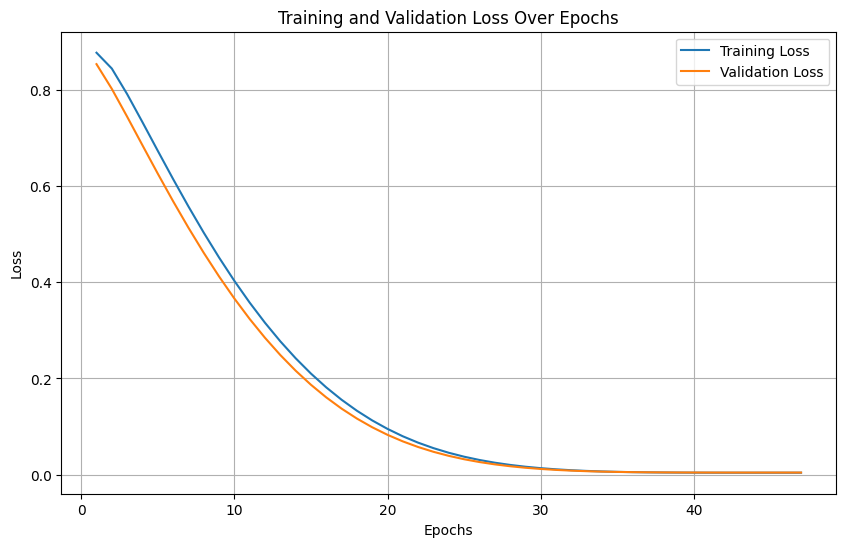

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
R² Score on Test Data: 0.8463


In [40]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training after 5 epochs without improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Include the early stopping callback
)
plot_loss_and_r2(model, history, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


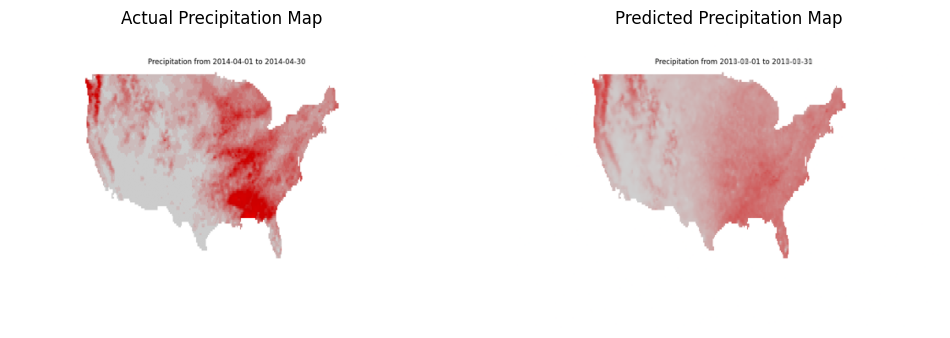

In [43]:
# Select a random date from the test set
y_pred = model.predict(X_test)
random_idx = np.random.randint(0, X_test.shape[0])
y_pred = y_pred.reshape(-1, 350, 500, 3)

actual_map = y_test[random_idx]
predicted_map = y_pred[random_idx]

# Plot the actual and predicted heatmaps
plt.figure(figsize=(12, 6))

# Plot the actual heatmap
plt.subplot(1, 2, 1)
plt.imshow(actual_map)
plt.title('Actual Precipitation Map')
plt.axis('off')

# Plot the predicted heatmap
plt.subplot(1, 2, 2)
plt.imshow(predicted_map)
plt.title('Predicted Precipitation Map')
plt.axis('off')

plt.show()

## 4.3 Transfer Learning

**Increase Model Complexity**  
- Adding complexity enables the model to capture more intricate patterns in the data, while transfer learning leverages pre-trained models to save time and improve performance, especially with limited data.

In [44]:
# Create sequences of images and their corresponding targets
def create_sequences(X, seq_length):
    sequences = []
    targets = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i + seq_length])
        targets.append(X[i + seq_length])
    return np.array(sequences), np.array(targets)

# Create sequences
seq_length = 8 # Number of months to look back
X_seq, y_seq = create_sequences(X, seq_length)

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

In [45]:
def create_transfer_learning_model(seq_length, input_shape=(350, 500, 3)):
    # Define input shape
    inputs = Input(shape=(seq_length,) + input_shape)

    # Load the pre-trained ResNet50 model, excluding the top layers
    base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_cnn.layers:
        layer.trainable = False

    # Function to apply the base CNN model
    def apply_cnn(x):
        return base_cnn(x)

    # Wrap the base CNN with TimeDistributed using Lambda
    x = TimeDistributed(Lambda(apply_cnn))(inputs)
    x = TimeDistributed(GlobalAveragePooling2D())(x)  # Use global average pooling to reduce dimensions

    # LSTM layers for sequence learning
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)

    # Fully connected layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(np.prod(input_shape), activation='sigmoid')(x)

    # Reshape output to the image shape
    outputs = Reshape(input_shape)(outputs)

    # Define the model
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

    return model

# Create the model
model = create_transfer_learning_model(seq_length)
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 8, 350, 500, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 8, 11, 16,      │             0 │
│ (TimeDistributed)               │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 8, 2048)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 8, 128)         │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 8, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 525000)         │   269,325,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 350, 500, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,211,976 (1.01 GB)

 Trainable params: 271,211,976 (1.01 GB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)   

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 21s/step - loss: 0.2062 - val_loss: 0.2065
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 16s/step - loss: 0.2062 - val_loss: 0.2065
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - loss: 0.2062 - val_loss: 0.2065
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 12s/step - loss: 0.2062 - val_loss: 0.2064
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.2061 - val_loss: 0.2064
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 13s/step - loss: 0.2061 - val_loss: 0.2064
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - loss: 0.2061 - val_loss: 0.2064
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 12s/step - loss: 0.2061 - val_loss: 0.2064
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - loss: 0.2061 - val_loss: 0.2063
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 14s/step - loss: 0.2060 - val_loss: 0.2063
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 13s/step - loss: 0.2060 - val_loss: 0.2062
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 12s/step - loss: 0.2059 - val_lo

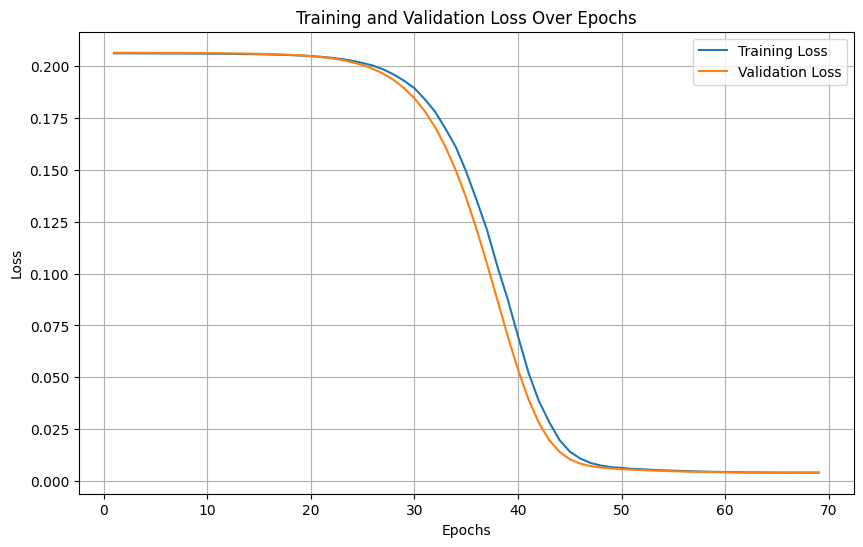

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
R² Score on Test Data: 0.8361


In [47]:
plot_loss_and_r2(model, history, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


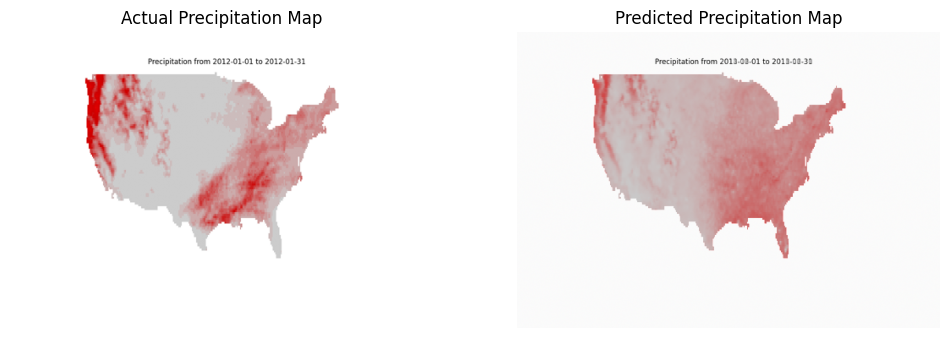

In [50]:
# Select a random date from the test set
y_pred = model.predict(X_test)
random_idx = np.random.randint(0, X_test.shape[0])
y_pred = y_pred.reshape(-1, 350, 500, 3)

actual_map = y_test[random_idx]
predicted_map = y_pred[random_idx]

# Plot the actual and predicted heatmaps
plt.figure(figsize=(12, 6))

# Plot the actual heatmap
plt.subplot(1, 2, 1)
plt.imshow(actual_map)
plt.title('Actual Precipitation Map')
plt.axis('off')

# Plot the predicted heatmap
plt.subplot(1, 2, 2)
plt.imshow(predicted_map)
plt.title('Predicted Precipitation Map')
plt.axis('off')

plt.show()

# 5. Further Steps

1. **Increase Sequence Size:**  
   - Longer sequences provide more temporal context, allowing the model to capture extended dependencies, especially useful for time-series or sequential data.

2. **Batch Normalization:**  
   - Normalizes activations within each batch, stabilizing and accelerating training while reducing sensitivity to initialization and learning rate.

3. **Dropout:**  
   - Randomly drops neurons during training, preventing overfitting by encouraging the model to generalize better to unseen data.

4. **Pooling Layers:**  
   - Reduces spatial dimensions in CNNs (e.g., MaxPooling, AveragePooling), decreasing computational load while retaining key features.

5. **Increase Model Capacity:**  
   - Add more layers or units to the model to capture complex patterns, but carefully balance against overfitting risks.

6. **Data Augmentation:**  
   - Expands the dataset by applying transformations (e.g., rotations, flips) to reduce overfitting and improve generalization.

7. **Learning Rate Schedules:**  
   - Dynamically adjusts the learning rate during training to improve convergence and fine-tuning.

8. **Regularization Techniques:**  
   - Add penalties like L1 or L2 regularization to the loss function to constrain weights and prevent overfitting.